# Сборный проект 5_Поиск по изображениям

## Содержание

* [Описание проекта](#Описание)
* [Импорт библиотек Python](#Импорт)
* [Загрузка данных](#Загрузка)
* [Предобработка данных](#Предобработка)
* [Исследовательский анализ данных](#Исследование)
* [Построение моделей машинного обучения](#Моделирование)
    * [Подготовка данных](#Моделирование_подготовка)
    * [Подготовка набора моделей и обучение на тренировочных данных](#Моделирование_обучение)
    * [Выбор лучшей модели и оценка на тестовом наборе данных](#Моделирование_тестирование)
* [Общий вывод](#Вывод)

## Описание проекта <a class = 'anchor' id = 'Описание'></a> 

На исследовании находятся `фотографии и описания к ним, размещаемые пользователями`, которые были предоставлены руководством фотохостинга "Со Смыслом".

---

`Задача`

Разработать модель машинного обучения для **анализа фотографий пользователей, а также описаний к ним** с целью:
* поиска связанных фотографий по текстовому запросу пользователя;
* защиты от публикации фотографий с лицами несовершеннолетних.

Необходимо добиться **максимально возможной сходимости изображений и текста в диапазоне значений от 0 до 1**

---

`Описание данных`

* папка `/datasets/train_images/` с фотографиями для тренировки модели;
* файл `train_dataset.csv` с разметкой, содержащий два столбца:
    * **image** — название файла фотографии;
    * **query_id** - идентификатор описания;
    * **query_text** — текст описания.
* файл `test_queries.csv` с информацией для тестирования модели:
    * - идентификатор запроса;
    * - текст запроса;
    * - релевантное изображение.
* файл `CrowdAnnotations.tsv` - данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
    * **image** - название файла фотографии;
    * **query_id** - идентификатор описания;
    * **confirm_share** - доля людей, подтвердивших, что описание соответствует изображению;
    * **confirm_count** - количество людей, подтвердивших, что описание соответствует изображению;
    * **nonConfirm_count** - количество людей, подтвердивших, что описание НЕ соответствует изображению.
* файл `ExpertAnnotations.tsv` - данные по соответствию изображения и описания, полученные с помощью экспертов:
    * **image** - название файла фотографии;
    * **query_id** - идентификатор описания;
    * **3, 4, 5** - оценки трех экспертов;

**Система оценок экспертов**

| Оценка | Значение |
|:------:|:---------:|
| 1       | Изображение и запрос совершенно не соответствуют друг другу |
| 2       | Запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует |
| 3       | Запрос и текст соответствуют с точностью до некоторых деталей |
| 4       | Запрос и текст соответствуют полностью |

---

`Путь решения`

1. Выполнить загрузку данных в рабочую среду;
2. Провести предобработку данных:
    * Агрегировать оценки экспертов - из трех оценок сделать одну;
    * Собрать данные (фотографии и описания) фотохостинга в единый датасет;
    * Вычислить взвешенную оценку на основании степени доверия к результатам краудсорс-исследования и экспертного исследования;
    * Выполнить очистку данных от контента, содержащего изображения лиц возрастом менее 16 лет;
3. Выполнить исследовательский анализ данных;
4. Выполнить векторизацию изображений с применением механизмов сверточных нейросетей;
5. Выполнить векторизацию текстовых описаний с применением механизмов NLP;
6. Выполнить объединение векторов изображений и текстовых описаний;
7. Обучить модель на подготовленных данных;
8. Провести тестирование модели на тестовых данных;
9. Сформировать вывод о подготовленных решениях.

## Импорт библиотек Python <a class  = 'anchor' id = 'Импорт'></a>

Данный блок характеризуется следующими последовательными действиями:
1. Импорт библиотек Python:
    * для манипулирования данными;
    * для визуализации данных;
    * для решения задач машинного обучения:
        * линейные модели машинного обучения
        * инструменты проектирования нейронных сетей для анализа изображений;
        * инструменты обработки естественного языка;
        * метрики оценки эффективности моделей;
        * механизмы отключения предупреждений.
2. Инициализация переменных-констант для последующего использования на этапе построения моделей МО;
3. Формирование вывода по итогам данного этапа.

In [1]:
# импорт библиотек python

# для манипулирования данными
import pandas as pd
import numpy as np

# для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# для решения задач машинного обучения
# линейные модели машинного обучения
from sklearn.linear_model import LinearRegression

# инструменты проектирования нейронных сетей для анализа изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

# для анализа и обработки текста
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# игнорирование возможных предупреждений
import warnings
warnings.filterwarnings("ignore")

# для получения пути к директории
import os

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\k.storozhuk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\k.storozhuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# инициализация констант для дальнейшего использования в проекте
# инициализация переменной SEED для фиксирования случайности
# инициализация переменной TEST_SIZE для фиксирования размера тестовой выборки при разбиении наборов данных
SEED = 12345
TEST_SIZE = 0.25

**Вывод**

1. Импортированы библиотеки Python:
    * для манипулирования данными:
        * pandas;
        * numpy.
    * для визуализации данных:
        * matplotlib.pyplot;
        * seaborn.
    * для решения задач машинного обучения:
        * линейные модели машинного обучения;
        * инструменты проектирования нейронных сетей для анализа изображений;
        * инструменты обработки естественного языка;
    * для отключения предупреждений.
2. Инициализированы переменные:
    * **TEST_SIZE** для фиксирования размера тестовой выборки при разбиении наборов данных;
    * **SEED** для фиксирования случайности.

## Загрузка данных <a class = 'anchor' id = 'Загрузка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Загрузка данных в рабочую среду Jupyter Notebook:
    * инициализация переменной для хранения пути к папке с изображениями;
    * загрузка данных из файлов `CSV` с оценками экспертов / пользователей;
    * загрузка обучающих / тренировочных данных из файлов `CSV` с идентификаторами изображений и текстовыми описаниями;
2. Инициализация пользовательских функций вывода информации:
    * для первичного изучения содержимого наборов данных;
    * для построения распределений количественных непрерывных показателей;
    * для подсчета уникальных значений.
3. Вывод на экран общей информации о каждом наборе данных:
    * вывод общей структуры набора данных - демонстрация первых 5 строк;
    * общей информации о наборе данных;
    * распределение количественных величин в наборе данных.
4. Формирование вывода по итогам данного этапа.

In [3]:
# инициализация переменной для получения пути к папке
dataset_path = os.path.join('..', 'datasets', 'to_upload')

In [4]:
# загрузка данных из директории с изображениями
try:
    train_queries = pd.read_csv(dataset_path + '\\train_dataset.csv')
    test_queries = pd.read_csv(dataset_path + '\\test_queries.csv', sep='|', index_col=[0])
    experts_df = pd.read_csv(dataset_path + '\\ExpertAnnotations.tsv', sep = '\t', names = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
    crowd_df = pd.read_csv(dataset_path + '\\CrowdAnnotations.tsv', sep = '\t', names = ['image', 'query_id', 'confirm_share', 'confirm_count', 'nonConfirm_count'])
except:
    train_queries = pd.read_csv('/datasets/to_upload/train_dataset.csv')
    test_queries = pd.read_csv('/datasets/to_upload/test_queries.csv')
    experts_df = pd.read_csv('/datasets/to_upload/ExpertAnnotations.tsv', sep = '\t', names = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
    crowd_df = pd.read_csv('/datasets/to_upload/CrowdAnnotations.tsv', sep = '\t', names = ['image', 'query_id', 'confirm_share', 'confirm_count', 'nonConfirm_count'])

In [5]:
# инициализация пользовательской функции для первичного изучения содержимого наборов данных
def first_meeting (df : pd.DataFrame, df_name : str) -> None:
    print(f'Структура набора данных {df_name}')
    display(df.head())
    print('Общая информация о наборе')
    print(df.info())
    print()

# инициализация пользовательской функции построения распределений количественных непрерывных показателей
def num_distribution(df : pd.DataFrame, column : str, bins : int):
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения признака \n{column}')
    plt.ylabel(f'Частота значений признака')
    plt.title(f'Гистограмма значений \n{column}', fontsize = 10)
    sns.histplot(data = df, x = df[column], bins = bins)
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения признака \n{column}')
    plt.title(f'Диаграмма размаха значений \n{column}', fontsize = 10)
    sns.boxplot(data = df, x = df[column])
    plt.grid(False)
    plt.show()

In [6]:
# вывод на экран структуры и основных параметров датасета test_queries
first_meeting(test_queries, 'test_queries')

Структура набора данных test_queries


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None



In [7]:
# вывод на экран структуры и основных параметров датасета train_queries
first_meeting(train_queries, 'train_queries')

Структура набора данных train_queries


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None



In [8]:
# вывод на экран параметров датасета 'experts_df'
first_meeting(experts_df, 'experts_df')

Структура набора данных experts_df


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
None



Структура набора данных crowd_df


,image,query_id,confirm_share,confirm_count,nonConfirm_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   confirm_share     47830 non-null  float64
 3   confirm_count     47830 non-null  int64  
 4   nonConfirm_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None



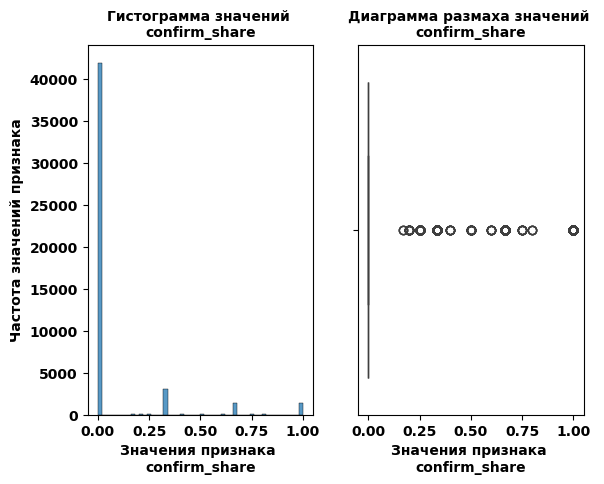

In [9]:
# вывод на экран параметров датасета 'crowd_df'
first_meeting(crowd_df, 'crowd_df')

# вывод на экран графика распределения непрерывной количественной величины 'confirm_share'
num_distribution(crowd_df, 'confirm_share', 50)

In [10]:
# инициализация пользовательской функции подсчета уникальных значений
def unique_count(df : pd.DataFrame, column : str) -> None:
    print(f'Количество уникальных значений в столбце {column} : {df[column].nunique()}')

In [11]:
# вывод на экран уникальных значений по столбцам
for column in ['image', 'query_id']:
    for df in [train_queries, test_queries, experts_df, crowd_df]:
        unique_count(df, column)

Количество уникальных значений в столбце image : 1000
Количество уникальных значений в столбце image : 100
Количество уникальных значений в столбце image : 1000
Количество уникальных значений в столбце image : 1000
Количество уникальных значений в столбце query_id : 977
Количество уникальных значений в столбце query_id : 500
Количество уникальных значений в столбце query_id : 977
Количество уникальных значений в столбце query_id : 1000


**Вывод по промежуточному этапу**

После подсчета уникальных значений по столбцам с обозначением изображений (**image**) и идентификаторами описаний (**query_id**) можно сделать промежуточный вывод о полноте данных:
* По столбцу **image**:
    * В тренировочном наборе, а также в результатах краудсорс- и экспертного исследований - по 1 000 уникальных фотографий (количественно наборы содержат одни и те же фотографии);
    * В тестовом наборе - 100 уникальных фотографий.
* По столбцу **query_id**:
    * В тренировочном наборе, а также в результате экспертного исследования - совпадение по количеству уникальных описаний (по 977);
    * В результате краудсорс-исследования - 1000 уникальных описаний (возможно, что в набор данных попали описания, которые не относятся к исследуемому набору данных)
    
*Необходимо проверить совпадение идентификаторов перед объединением наборов данных*

**Вывод**

1. Произведена загрузка данных в рабочую среду Jupyter Notebook:
    * инициализирована переменная для хранения пути к папке с данными - **dataset_path**;
    * инициализированы переменные для хранения данных с оценками экспертов / пользователей:
        * **crowd_df** - данные краудсорс-исследования;
        * **experts_df** - данные экспертного исследования;
    * загружены обучающие / тренировочные данные из файлов `CSV` с идентификаторами изображений и текстовыми описаниями:
        * **train_queries** - тренировочные данные;
        * **test_queries** - тестовые данные.
2. Произведена инициализация пользовательских функций вывода информации:
    * для первичного изучения содержимого наборов данных - **first_meeting**;
    * для построения распределений количественных непрерывных показателей - **num_distribution**;
    * для подсчета уникальных значений - **unique_count**.
3. Выведена на экран общей информация о каждом наборе данных:
    * Распределение количественных величин по признаку **confirm_share** показывает, что в подавляющем большинстве пользователи **не согласны** с тем, что описание соответствует изображению;
    * Проведено вычисление уникальных значений по столбцам **image** и **query_id**:
        * По столбцу **image**:
            * В тренировочном наборе, а также в результатах краудсорс- и экспертного исследований - по 1 000 уникальных фотографий (количественно наборы содержат одни и те же фотографии);
            * В тестовом наборе - 100 уникальных фотографий.
        * По столбцу **query_id**:
            * В тренировочном наборе, а также в результате экспертного исследования - совпадение по количеству уникальных описаний (по 977);
            * В результате краудсорс-исследования - 1000 уникальных описаний (возможно, что в набор данных попали описания, которые не относятся к исследуемому набору данных)
    
Таким образом, необходимо:
* дополнительно проверить совпадение идентификаторов перед объединением наборов данных - выявить описания **crowd_df**, которые не относятся к исследуемому набору данных;
* дополнительно оценить абсолютные и относительные значения из набора **crowd_df**, чтобы сделать последующий выбор в использовании этих значений.

## Предобработка данных <a class = 'anchor' id = 'Предобработка'></a>

Данный блок характеризуется следующими последовательными действиями:

1. Агрегация оценок экспертов - выполнить преобразование трех оценок в одну;
2. Объединение наборов данных - сборка единого датасета;
3. Вычисление взвешанной оценки на основании степени доверия к результатам краудсорс- и экспертного исследований;
4. Очистка набора данных от контента с лицами младше 16 лет.

**Допущение при о оценкам экспертов**

Так как в описании задачи сказано, что оценки по шкале от **1 до 4** означают разную степень соответствия изображения и описания, то можно принять следующее для агрегации оценок:
* Значения 1 и 2 классифицируются как **несоответствие** описания изображению - присваивается значение 0;
* Значения 3 и 4 классифицируются как **соответствие** описания изображению - присваивается значение 1.

По итогам замены исходных оценок на бинарные значения можно вычислить среднее значение по трем оценкам и сравнить его с пороговым значением - **threshold_value** - для принятия решения о соответствии описания изображению.

In [12]:
# инициализация пользовательской функции агрегирования экспертных оценок
def aggregate_experts (row, threshold_value = 0.5) -> int:
    expert_values = row[['expert_1', 'expert_2', 'expert_3']]
    binary_values = expert_values.apply(lambda x: 0 if x <= 2 else 1)
    mean_value = binary_values.mean()
    if mean_value >= threshold_value:
        return 1
    else:
        return 0

In [13]:
# применение пользовательской функции агрегации оценок к набору данных
experts_df = (
    experts_df
    .drop(columns=['expert_1', 'expert_2', 'expert_3'])
    .assign(agg_exp = experts_df.apply(aggregate_experts, axis=1))
)

# изучение преобразований
experts_df.head()

,image,query_id,agg_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0


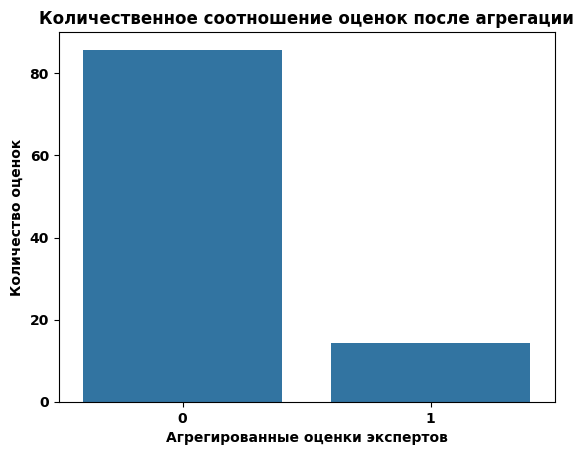

In [14]:
# построение графика количественного соотношения оценок после агрегации
sns.countplot(data = experts_df, x = 'agg_exp', stat = 'percent')
plt.title('Количественное соотношение оценок после агрегации', fontsize = 12)
plt.xlabel('Агрегированные оценки экспертов')
plt.ylabel('Количество оценок')
plt.show()

**Вывод по промежуточному этапу**

По итогам преобразования оценок экспертов получены бинарные значения:
* **0** - описание не соответствует изображению;
* **1** - описание соответствует изображению.

По итогам визуализации количественного соотношения оценок можно сделать вывод о том, что в большинстве случаев описание **НЕ соответствует** изображению.

In [15]:
# изучение уникальных значений пользователей из краудсорс-исследования
print(f'Сколько пользователей было привлечено к краудсорсингу (на основании метрики "confrirm_count"): {crowd_df['confirm_count'].max()}')
print(f'Сколько пользователей было привлечено к краудсорсингу (на основании метрики "nonConfirm_count"): {crowd_df['nonConfirm_count'].max()}')

Сколько пользователей было привлечено к краудсорсингу (на основании метрики "confrirm_count"): 5
Сколько пользователей было привлечено к краудсорсингу (на основании метрики "nonConfirm_count"): 6


**Вывод по промежуточному этапу**

Расчет количества пользователей, принявших участие в краудсорсинге на основании двух метрик было не случайным - необходимо было понять, находятся ли показатели **confirm_count** и **nonConfirm_count** в балансе, чтобы в дальнейшем применить методику преобразования значений, которая была применена к набору данных с результатами экспертов.

Так, как в одном случае максимальное количество пользователей равно 5, а в другом - 6, то можно сказать, что применить методику преобразования абсолютных значений в данном случае не получится

Для последующих действий можно использовать относительные значения - **confirm_share**.

In [16]:
# преобразование значений в столбце 'confirm_share' в бинарные значения
crowd_df['agg_crowd'] = crowd_df['confirm_share'].apply(lambda x: 1 if x > 0.5 else 0)

# просмотр преобразований
crowd_df.head()

,image,query_id,confirm_share,confirm_count,nonConfirm_count,agg_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0,1
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3,0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3,0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3,0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3,0


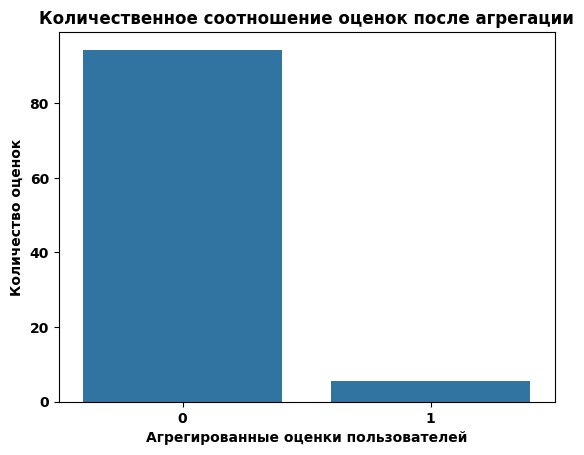

In [17]:
# построение графика количественного соотношения оценок после агрегации
sns.countplot(data = crowd_df, x = 'agg_crowd', stat = 'percent')
plt.title('Количественное соотношение оценок после агрегации', fontsize = 12)
plt.xlabel('Агрегированные оценки пользователей')
plt.ylabel('Количество оценок')
plt.show()

**Вывод по промежуточному этапу**

По итогам преобразования оценок пользователей получены бинарные значения:
* **0** - описание не соответствует изображению;
* **1** - описание соответствует изображению.

По итогам визуализации количественного соотношения оценок можно сделать вывод о том, что в большинстве случаев описание **НЕ соответствует** изображению.

In [18]:
# объединение наборов данных - инициализация переменной 'train_dataset'
train_dataset = (train_queries
                 .merge(experts_df[['image', 'query_id', 'agg_exp']], on = ['image', 'query_id'], how = 'left')
                 .merge(crowd_df[['image', 'query_id', 'agg_crowd']], on = ['image', 'query_id'], how = 'outer'))

In [19]:
# вывод основной информации об объединенном наборе
first_meeting(train_dataset, 'train_dataset')

Структура набора данных train_dataset


,image,query_id,query_text,agg_exp,agg_crowd
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,0.0


Общая информация о наборе
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  5822 non-null   object 
 3   agg_exp     5822 non-null   float64
 4   agg_crowd   47830 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB
None



**Вывод по промежуточному этапу**

По результатам объединения получен общий набор данных, содержащий 5 столбцов:
* image;
* query_id;
* query_text;
* agg_exp - агрегированная оценка экспертов;
* agg_crowd - агрегированная оценка пользователей.

В столбцах **query_text**, **agg_exp** и **agg_crowd** присутствуют пропущенные значения, появившиеся из-за способов объединения **left** и **outer**.

Также не исключено появление дубликатов по причине способа объединения **outer** - необходимо дополнительно исследовать этот момент.

In [20]:
# создание датафрейма с уникальными значениями 'query_id - query_text' из общего набора данных
query_id_text_pairs = train_queries[['query_id', 'query_text']].drop_duplicates()

In [21]:
# заполнение пропусков по столбцу 'query_text' через объединение таблиц
train_dataset = train_dataset.drop(columns=['query_text']).merge(query_id_text_pairs, on=['query_id'], how='left')

# повторный вывод основной информации об объединенном наборе
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   agg_exp     5822 non-null   float64
 3   agg_crowd   47830 non-null  float64
 4   query_text  50214 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [22]:
# создание столбца со взвешенными значениями оценок экспертов и пользователей
# предварительно применяется заполнение пропусков нулевыми значениями
train_dataset['target'] = (train_dataset['agg_exp'].fillna(0) * 0.6 +
                           train_dataset['agg_crowd'].fillna(0) * 0.4)

# исключение из набора исходных столбцов для расчета таргета
train_dataset = train_dataset.drop(['agg_exp', 'agg_crowd'], axis = 1)

# вывод на экран общей информации о наборе данных
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [24]:
# вычисление доли пропущенных значений
print('Доля пропущенных значений по столбцу "query_text" от общего набора: {:.1%}'.format(train_dataset.query_text.isna().sum() / len(train_dataset)))

Доля пропущенных значений по столбцу "query_text" от общего набора: 2.2%


In [25]:
# исключение "избыточных" строк из набора для приведения записей к общей "базе"
train_dataset = train_dataset.dropna(axis = 'index')

# вывод на экран общей информации о наборе
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   target      50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


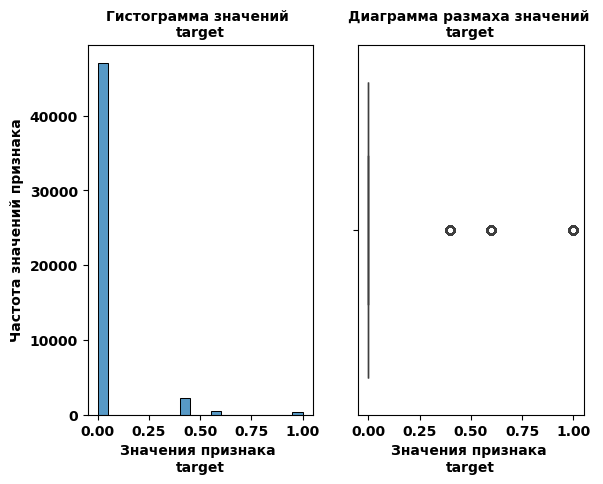

In [27]:
# визуализация распределения взвешенной оценки
num_distribution(train_dataset, 'target', 20)